# 1. Install packages

In [1]:
!pip install tensorflow opencv-python matplotlib albumentations 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Import our packages and build image loading function

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import numpy as np

In [3]:
def load_image(image):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [400, 400])
    return img

In [4]:
images = tf.data.Dataset.list_files('data\\training\\images\\*.jpg', shuffle=True).map(load_image)

## Plot some training samples

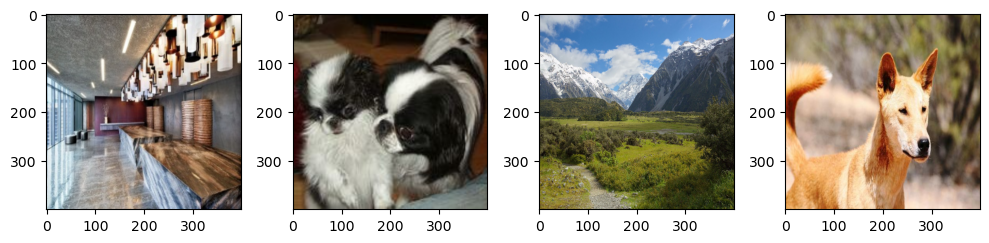

In [5]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
plot_images = plot_images / 255.0

fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for id, img in enumerate(plot_images):
    ax[id].imshow(img)
fig.tight_layout()
plt.show()

# 3. Crete augmentation pipline

In [6]:
import albumentations as A
import os
import cv2

C:\Users\oskar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [7]:
IMAGE_SIZE = 224

augmentor = A.Compose(
    [A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RGBShift(p=0.2),
    A.VerticalFlip(p=0.5)],
    bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])
)

In [9]:
GENERARTE_AUGMENTED_IMAGES = False 
AUGMENTATIONS_PER_IMAGE = 30
if GENERARTE_AUGMENTED_IMAGES:
    for partition in ['training', 'validation', 'test']:
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))
            object_cords = [0, 0, 0.00001, 0.00001]
            label_path = os.path.join('data', partition, 'images', f'{image.split(".")[0]}.json')
            # check if label json exists 
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)
                # extract and normalize bbox coordinates
                object_cords[0] = label['shapes'][0]['points'][0][0]
                object_cords[1] = label['shapes'][0]['points'][0][1]
                object_cords[2] = label['shapes'][0]['points'][1][0]
                object_cords[3] = label['shapes'][0]['points'][1][1]

                img_w = img.shape[0]
                img_h = img.shape[1]

                object_cords = list(np.divide(
                    object_cords,
                    [img_w, img_h, img_w, img_h]
                ))
            
            # augment every image AUGMENTATIONS_PER_IMAGE
            try:
                for i in range(AUGMENTATIONS_PER_IMAGE):
                    augmented_img = augmentor(
                        image=img,
                        bboxes=[object_cords],
                        class_labels=['dog'])

                    cv2.imwrite(
                        os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{i}.jpg'),
                        augmented_img['image']
                    )

                    annotation = {}
                    annotation['image'] = image
                    # create cla
                    if os.path.exists(label_path):
                        annotation['bbox'] = augmented_img['bboxes'][0]
                        annotation['class'] = 1
                    else: 
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0

                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{i}.json'), 'w') as f:
                        json.dump(annotation, f)
            except Exception as e:
                print(e)